In [1]:
import pandas as pd
import numpy as np

from sqlalchemy import create_engine

import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading

In [2]:
conn = create_engine('sqlite:///data/starbucks_data.db')

# Loading the offers data without the channel column for simplicity
offers = pd.read_sql('SELECT DISTINCT offer_id, offer_duration, offer_type, offer_spend_minimum, offer_reward, offer_reward_vs_spend FROM offers', conn)
# Used for calculating the offer expiration time for each user and offer combination
offer_duration = offers[['offer_id', 'offer_duration']].drop_duplicates()

# Loading the interactions data
interactions = pd.read_sql('SELECT * FROM interactions', conn)

# Loading the user data for the user demographics
users = pd.read_sql('SELECT user_id, user_gender, user_tenure, user_age_group, user_income_group FROM users', conn)

# Adding back categorical columns for the users that were lost by saving to the database
users['user_gender'] = users['user_gender'].fillna('N/A')
user_gender_cats = [ 'N/A', 'O', 'F', 'M' ]
users['user_gender'] = pd.Categorical(users['user_gender'], categories=user_gender_cats, ordered=True)

users['user_age_group'] = users['user_age_group'].fillna('N/A')
user_age_cats = ['N/A', '18-24', '25-34', '35-44', '45-54', '55-64', '65+']
users['user_age_group'] = pd.Categorical(users['user_age_group'], categories=user_age_cats, ordered=True)

user_income_cats = ['N/A', '<50k', '50k-75k', '75k-100k', '>100k']
users['user_income_group'] = pd.Categorical(users['user_income_group'], categories=user_income_cats, ordered=False)

## Structuring the Interactions by Type

Separating out the interactions by their types: recieved offers, viewed offers, completed offers, and transactions

In [3]:
base_col_order = ['user_id', 'offer_id', 'intxn_event_type', 'intxn_time', 'intxn_amount', 'intxn_reward']

offer_received = interactions[ interactions['intxn_event_type'] == 'offer received' ].copy().drop(['intxn_event_type', 'intxn_amount', 'intxn_reward'], axis=1)
offer_received_cols = [ "received" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_received.columns ]
offer_received.columns = offer_received_cols

offer_received = pd.merge(offer_received, offer_duration, how='left', on='offer_id')
offer_received['expiration_time'] = offer_received['received_time'] + offer_received['offer_duration']
offer_received = offer_received.drop(columns=['offer_duration'])

offer_viewed = interactions[ interactions['intxn_event_type'] == 'offer viewed' ].copy().drop(['intxn_event_type', 'intxn_amount', 'intxn_reward'], axis=1)
offer_viewed_cols = [ "viewed" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_viewed.columns ]
offer_viewed.columns = offer_viewed_cols

offer_completed = interactions[ interactions['intxn_event_type'] == 'offer completed' ].copy().drop(['intxn_event_type', 'intxn_amount', 'intxn_reward'], axis=1)
offer_completed_cols = [ "completed" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in offer_completed.columns ]
offer_completed.columns = offer_completed_cols

transactions = interactions[ interactions['intxn_event_type'] == 'transaction' ].copy().drop(['offer_id', 'intxn_event_type', 'intxn_reward'], axis=1)
transactions_cols = [ "transaction" + cn.removeprefix('intxn') if 'intxn' in cn else cn for cn in transactions.columns ]
transactions.columns = transactions_cols

# Customer Journey Creation

## Viewed offers compared to received offers

Joining the offers received to the offers viewed to filter out those received offers that were not viewed

In [4]:
# Merging offer_received to offer_viewed to get the offer expiration times
offer_interactions = pd.merge( offer_received, offer_viewed, on=['user_id', 'offer_id'], how='left' )
offer_interactions = offer_interactions[ ~offer_interactions['viewed_time'].isna() ]

# Removing duplicates from the join where the received time would be after the viewed time and the viewed time would be after the expiration time
offer_interactions = offer_interactions[  ( offer_interactions['viewed_time'] >= offer_interactions['received_time'] ) & ( offer_interactions['viewed_time'] <= offer_interactions['expiration_time'] ) ]
offer_interactions = offer_interactions.sort_values(['user_id', 'received_time', 'expiration_time', 'viewed_time']).drop_duplicates(subset=['offer_id', 'user_id', 'received_time', 'expiration_time'], keep='first')

## Recieved/Viewed Offers VS Transactions

Joining the dataframe created above to the transactions to see which offers that were received and viewed had transactions afterwards.

In [5]:
offer_interactions = pd.merge( offer_interactions, transactions, on=[ 'user_id' ], how='left' )
# Removing duplicates from the join where the recieved time would be after the transaction time
offer_interactions = offer_interactions[ ( offer_interactions['transaction_time'].isna() ) | ( offer_interactions['transaction_time'] >= offer_interactions['received_time'] ) ]
# Removing duplicates from the join where the viewed time would be after the transaction time
offer_interactions = offer_interactions[ ( offer_interactions['transaction_time'].isna() ) | ( offer_interactions['transaction_time'] >= offer_interactions['viewed_time'] ) ]
# Removing duplicates from the join where the transaction time would be after the expiration time
offer_interactions = offer_interactions[ ( offer_interactions['transaction_time'].isna() ) | ( offer_interactions['transaction_time'] <= offer_interactions['expiration_time'] ) ]

# Dropping duplicates from the join where the same transaction was applied to multiple offers and only keeping the first one
offer_interactions = offer_interactions \
                        .sort_values(['user_id', 'received_time', 'expiration_time', 'viewed_time', 'transaction_time']) \
                        .drop_duplicates( subset=['offer_id', 'user_id', 'received_time', 'expiration_time', 'viewed_time'], keep='first' )
offer_interactions = offer_interactions.drop(columns=['transaction_amount'])

## Recieved/Viewed offers VS Completions

Joining the above dataframe to the offer completions to see how many of the offers were completed.

In [6]:
offer_interactions = pd.merge( offer_interactions, offer_completed, on=[ 'user_id', 'offer_id' ], how='left' )
# Removing duplicates from the join where the completed time does not match the transaction time
offer_interactions = offer_interactions[ ( offer_interactions['completed_time'].isna() ) | ( offer_interactions['completed_time'] == offer_interactions['transaction_time'] ) ]
# Removing duplicates where there are multiple completed times for the same offer and user and only keeping the first one
offer_interactions = offer_interactions \
                        .sort_values(['user_id', 'received_time', 'expiration_time', 'viewed_time', 'transaction_time', 'completed_time']) \
                        .drop_duplicates(subset=['offer_id', 'user_id', 'received_time', 'expiration_time', 'viewed_time', 'transaction_time'], keep='first')

# Creating flags

In [7]:
# Creating had_transaction column to indicate if the user had a transaction for the offer
offer_interactions['had_transaction'] = ~offer_interactions['transaction_time'].isna()
offer_interactions['had_transaction'] = offer_interactions['had_transaction'].apply( lambda x: 1 if x else 0 )

# Creating completed_offer column to indicate if the user completed the offer
offer_interactions['completed_offer'] = ~offer_interactions['completed_time'].isna()
offer_interactions['completed_offer'] = offer_interactions['completed_offer'].apply( lambda x: 1 if x else 0 )

# Aggregating the data by user and offer since a user can have multiple of the same offer
offer_interactions = offer_interactions \
                        .groupby( ['user_id', 'offer_id'], observed=False, dropna=False ) \
                        .agg( offer_transactions=( 'had_transaction', 'sum' ), offer_completions=( 'completed_offer', 'sum') ) \
                        .reset_index()

In [8]:
# Joining the offer information and user demographics to the offer interactions data
offer_demographics = pd.merge( offer_interactions, users, on='user_id', how='left' )
offer_demographics = pd.merge( offer_demographics, offers, on='offer_id', how='left' )

# Aggregating by Offer and User Information

In [11]:
def get_aggregate_percentages( offer_demographics, group_by_cols ):
    """
    Helper function to get the aggregated offer completion percentage.

    Parameters:
    offer_demographics (pandas Dataframe): The dataframe containing the offer information and user demographics by user and offer.
    group_by_cols (list): The combination of columns to be used aggregation.

    Returns:
    Dataframe: The aggregated pandas dataframe with the offer completion percentage by the group_by_cols.
    """
    aggregated_offers = offer_demographics \
                        .groupby( group_by_cols, observed=True ) \
                        .agg( 
                            total_offers=('offer_transactions', 'count'), 
                            offer_completions=('offer_completions', 'sum')
                        ) \
                        .reset_index()

    aggregated_offers['comp_percent'] = round( aggregated_offers['offer_completions'] / aggregated_offers['total_offers'] * 100, 2 )
    return aggregated_offers.sort_values( 'offer_type' )

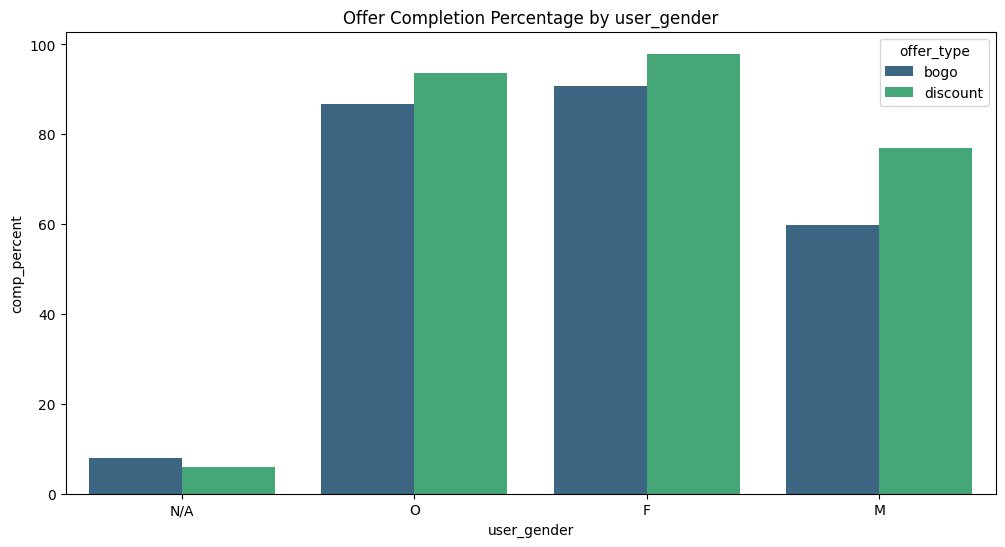

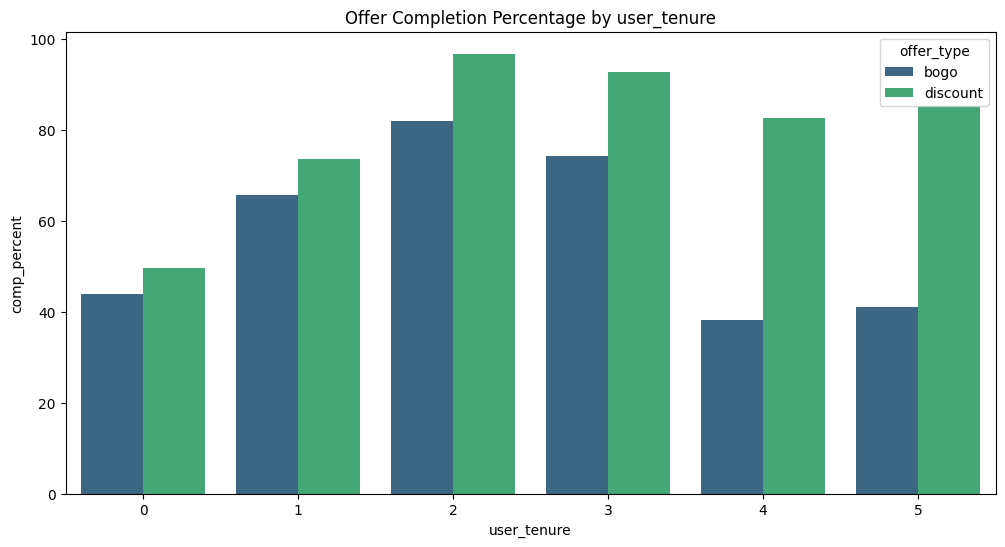

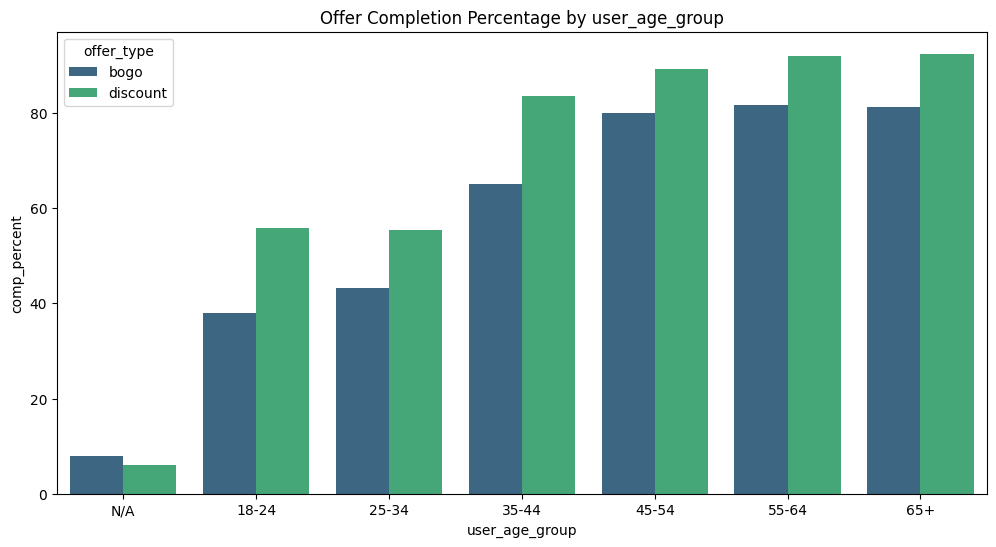

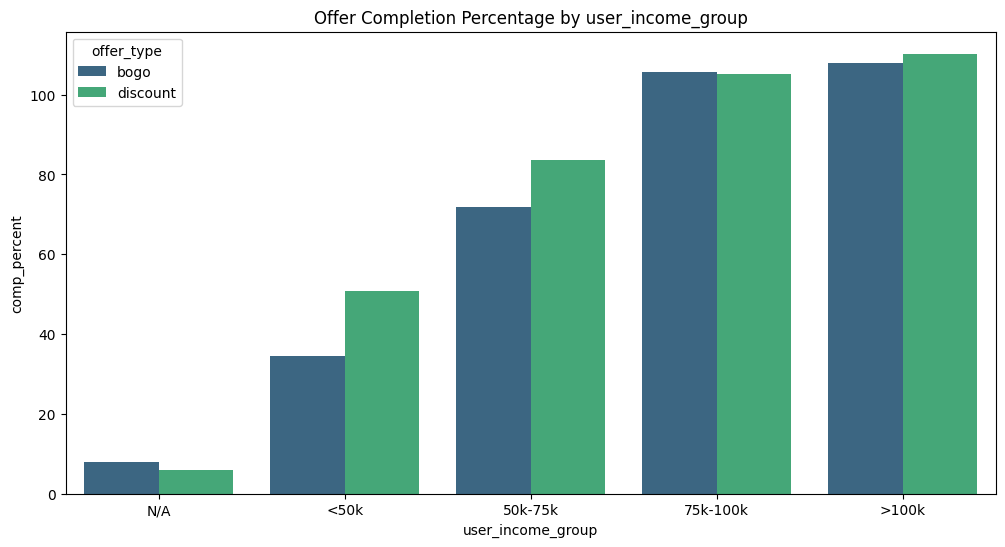

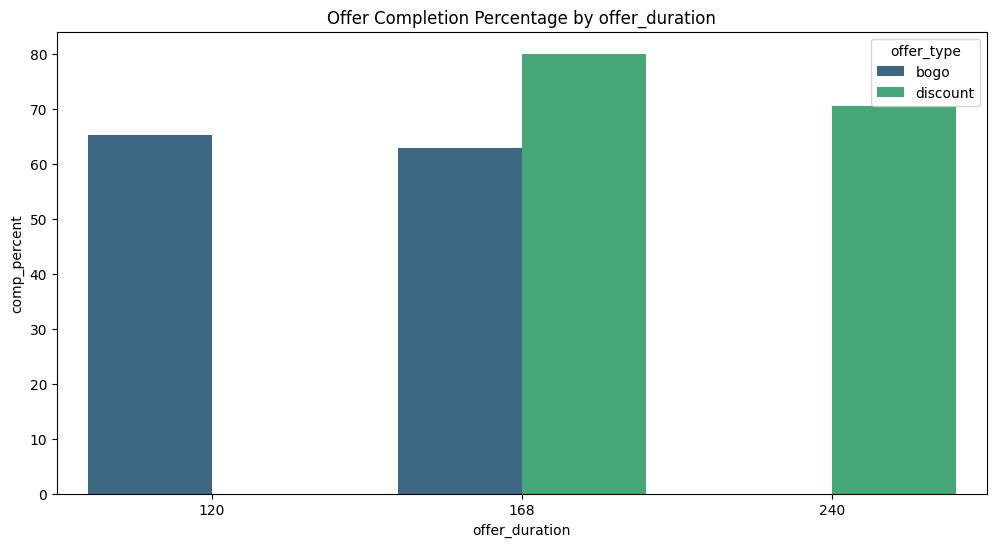

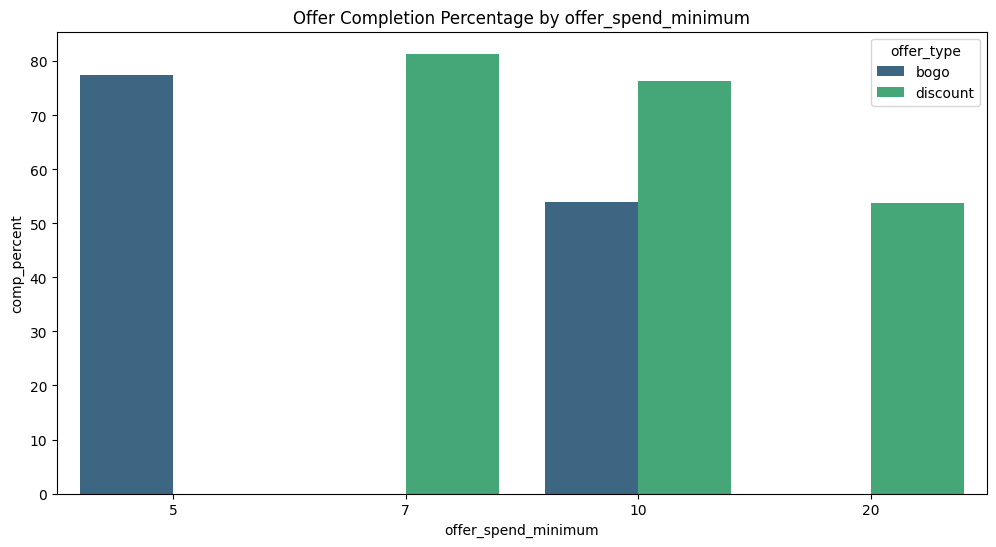

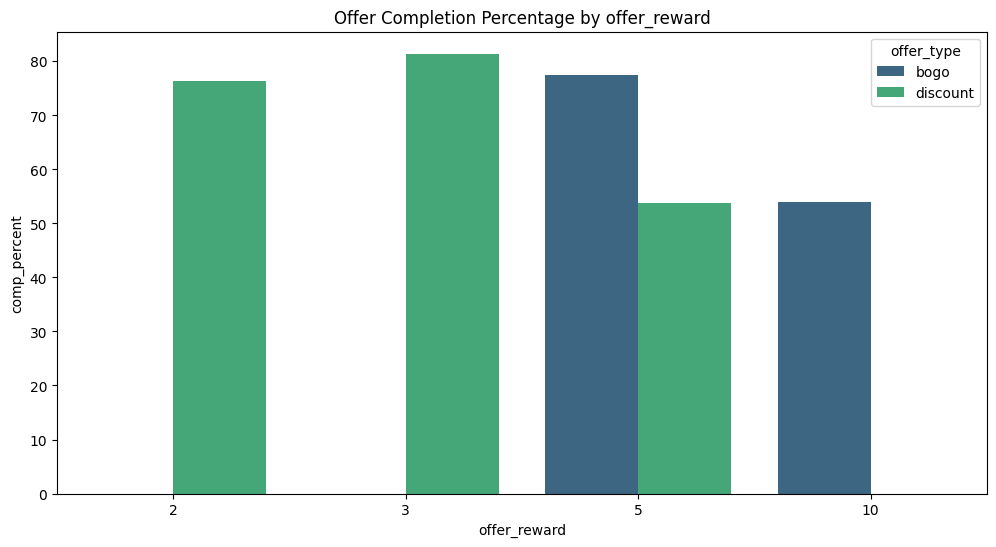

In [16]:
# Listing out the columns to be used as features for the graphs
feature_cols = [ 'user_gender', 'user_tenure', 'user_age_group', 'user_income_group', 'offer_duration', 'offer_spend_minimum', 'offer_reward' ]

# Generating the graphs for each feature
for feat in feature_cols:
    # Getting the aggregate percentages for the offer type and feature
    offer_agg = get_aggregate_percentages( offer_demographics, [ 'offer_type', feat ] )
    # Filtering out the rows with 0 completion percentage. This will also remove the 'informational' offer type since it will always be 0
    offer_agg = offer_agg[ offer_agg['comp_percent'] > 0 ]

    # Only plotting the graphs if there are any rows with completion percentage greater than 0
    if offer_agg.shape[0] > 0:
        plt.figure(figsize=(12, 6))
        curr_plot = sns.barplot(data=offer_agg, x=feat, y='comp_percent', hue='offer_type', hue_order=['bogo', 'discount'], palette='viridis')
        curr_plot.title.set_text(f"Offer Completion Percentage by {feat}")

        plt.savefig(f"docs/images/offer_completion_by_{feat}.png")